In [2]:
from gcp_fx import PROJECT_ID, pd, query_bq
import spacy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
query_bq('''select min(refresh_date),max(refresh_date) FROM `bigquery-public-data.google_trends.top_terms`''')

,f0_,f1_
0,2024-10-31,2024-12-01


In [6]:
NER = spacy.load("en_core_web_sm")
def get_entity(s):
    ''' for a string return an entity type

        PERSON: Refers to individuals, including fictional and real people.
        NORP: Represents nationalities, religious or political groups.
        FAC: Denotes buildings, airports, highways, bridges, etc.
        ORG: Refers to organizations such as companies, institutions, agencies, etc.
        GPE: Represents countries, cities, states, and other geopolitical entities.
        LOC: Denotes non-GPE locations such as mountains, bodies of water, etc.
        PRODUCT: Represents objects, vehicles, food items, etc.
        EVENT: Denotes named events like hurricanes, battles, wars, etc.
        WORK_OF_ART: Represents books, paintings, songs, etc.
        LAW: Denotes named laws and regulations.
        LANGUAGE: Represents named languages.
        DATE: Represents dates in various formats.
        TIME: Denotes times in various formats.
        PERCENT: Represents percentage values.
        MONEY: Denotes monetary values.
        QUANTITY: Represents measurements, quantities, or counts.
        ORDINAL: Denotes first, second, third, etc.
        CARDINAL: Represents numerical values, counting numbers.
    '''
    if NER(s).ents:
        return NER(s).ents[0].label_
    else:
        return ''

In [8]:
get_entity('John Doe')
get_entity('New York')

'PERSON'

'GPE'

In [9]:
sql = ''' SELECT refresh_date AS Day, term AS Top_Term
FROM `bigquery-public-data.google_trends.top_terms`
WHERE rank = 1
GROUP BY Day, Top_Term, rank
ORDER BY Day DESC'''

df = query_bq(sql).assign(ent=lambda x: [get_entity(s) for s in x.Top_Term])
df.head()
df.tail()

shape = (32, 2)
columns =  ['Day', 'Top_Term']


,Day,Top_Term,ent
0,2024-12-01,Michigan vs Ohio State,GPE
1,2024-11-30,Georgia football,GPE
2,2024-11-29,NFL,ORG
3,2024-11-28,Thanksgiving,DATE
4,2024-11-27,Champions League,ORG


,Day,Top_Term,ent
27,2024-11-04,How to vote in the U.S,GPE
28,2024-11-03,Georgia football,GPE
29,2024-11-02,Daylight savings time,
30,2024-11-01,Jets,
31,2024-10-31,Halloween,DATE


In [ ]:
def add_ttl(_df):
    return (
        df
        .assign(ttl=lambda x: x.groupby('ent').transform('size'))
        .sort_values('ttl',ascending=False)
    )
df.pipe(add_ttl)  
# perhaps a newer downlaod of the web corpus would have less blanks. or maybe the larger model

,Day,Top_Term,ent,ttl
16,2024-11-15,Eagles,,8
13,2024-11-18,Bengals,,8
30,2024-11-01,Jets,,8
29,2024-11-02,Daylight savings time,,8
26,2024-11-05,Election polls,,8
24,2024-11-07,Presidential election,,8
9,2024-11-22,Steelers,,8
11,2024-11-20,Dr. Oz,,8
28,2024-11-03,Georgia football,GPE,7
27,2024-11-04,How to vote in the U.S,GPE,7


           8
GPE        7
ORG        6
PERSON     6
DATE       3
NORP       1
PRODUCT    1
Name: ent, dtype: int64


<Axes: >

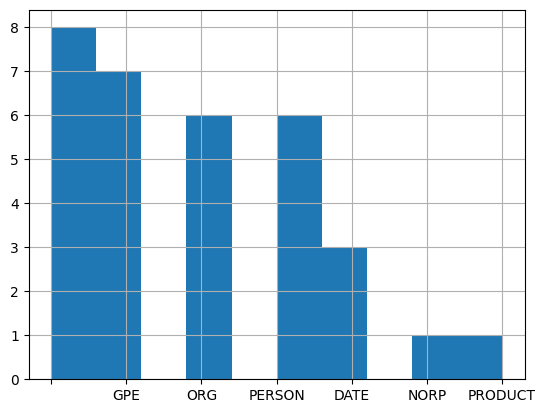

In [24]:
print(df.ent.value_counts())
df.pipe(add_ttl).ent.hist()

#### conclusion: 
we usually google places, orgs, people, and then dates